# Install Dependencies

In [1]:
# install.packages("gbm")
# install.packages("moments")
# install.packages("stringr")
# install.packages("ggplot2")
# install.packages("xgboost")
# install.packages("reshape2")

# Import Libraries

In [2]:
library(gbm)
library(stats)
library(moments)
library(stringr)
library(ggplot2)
library(xgboost)
library(reshape2)


Loaded gbm 2.1.8.1



# Read the Dataframe

In [3]:
# download and unzip the csv file from this page:
# https://www.kaggle.com/datasets/velatdicleli/ev-fiyatlar-2023
df <- read.csv("/kaggle/input/ev-fiyatlar-2023/istanbul_satilik_evler_2023.csv")
dim(df) # print shape of the dataframe

[1] 92693     6

In [4]:
df[c(63278:63289), ] # show corrupted rows

,Price,Room,Area,Age,Location,Floor
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
63278,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR
63279,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR
63280,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR
63281,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR
63282,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR
63283,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR
63284,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR
63285,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR
63286,PRICE,ROOM,AREA,AGE,LOCATION,FLOOR


In [5]:
df <- df[-c(63278:63289), ] # drop corrupted rows

In [6]:
dim(df)

[1] 92681     6

In [7]:
# df[c("room_num", "saloon_num")] <- strsplit(df$Room, " \\+ ", fixed = TRUE)
split_values <- str_split(df$Room, pattern = " \\+ ", simplify = TRUE)

# Assign split values to new columns
df$room_num <- split_values[, 1]
df$saloon_num <- split_values[, 2]
df <- df[, -which(names(df) == "Room")]


In [8]:
head(df)

,Price,Area,Age,Location,Floor,room_num,saloon_num
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,5200000,250,50,Adalar,2,2,1
2,1700000,115,30,Adalar,2,2,1
3,1700000,115,30,Adalar,2,2,1
4,23500000,430,0,Adalar,4,2,1
5,1900000,90,30,Adalar,1,2,1
6,3100000,110,31,Adalar,2,3,1


In [9]:
df$Price <- as.numeric(df$Price)
df$Area <- as.numeric(df$Area)
df$Age <- as.numeric(df$Age)
df$Floor <- as.numeric(df$Floor)
df$room_num <- as.numeric(df$room_num)
df$saloon_num <- as.numeric(df$saloon_num)


# Outlier Detection

Before shape in outlier detection: 92681 7 
After shape in outlier detection: 84266 7 


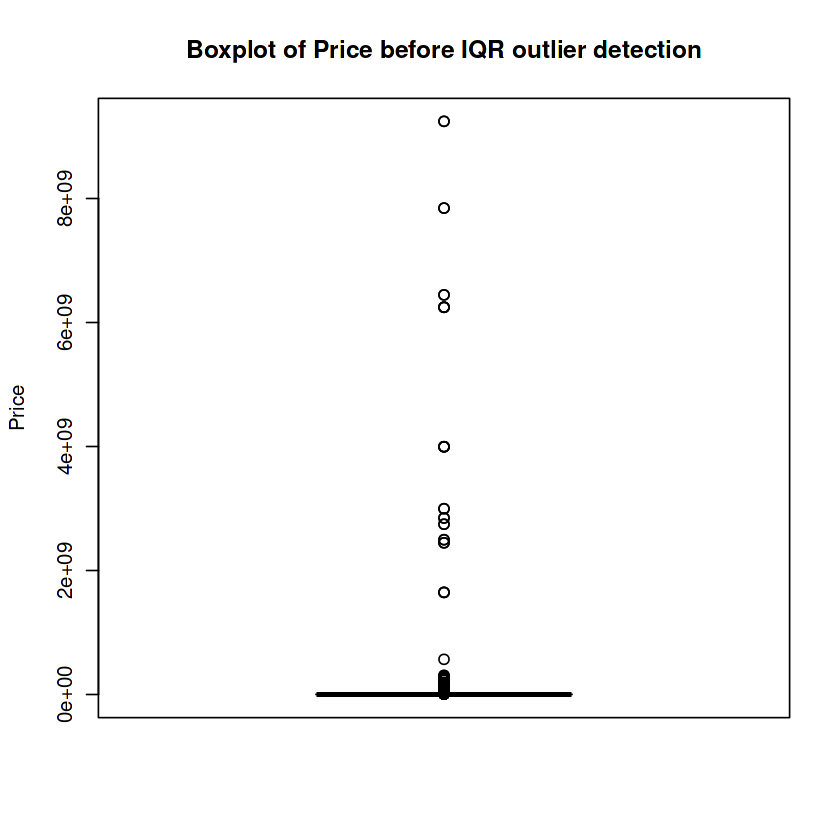

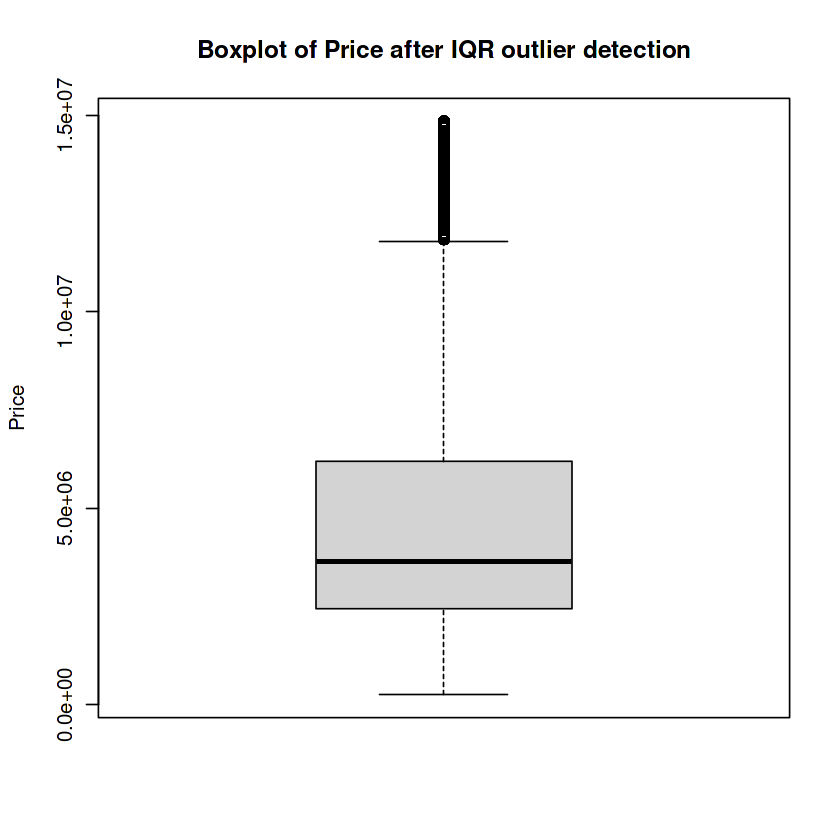

In [10]:
boxplot(df$Price, main = "Boxplot of Price before IQR outlier detection", ylab = "Price")
cat("Before shape in outlier detection:", dim(df), "\n")
Q1 <- quantile(df$Price, 0.25)
Q3 <- quantile(df$Price, 0.75)
IQR <- Q3 - Q1

# Step 2: Define lower and upper bounds
lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR

# Step 3: Identify outliers
outliers <- df[df$Price < lower_bound | df$Price > upper_bound, ]

# Step 4: Optional - Remove or flag outliers
# Option 1: Remove outliers from the dataframe
df <- df[df$Price >= lower_bound & df$Price <= upper_bound, ]
df <- df[df$Price > 35000, ]

cat("After shape in outlier detection:", dim(df), "\n")
boxplot(df$Price, main = "Boxplot of Price after IQR outlier detection", ylab = "Price")

Rejection 115 points


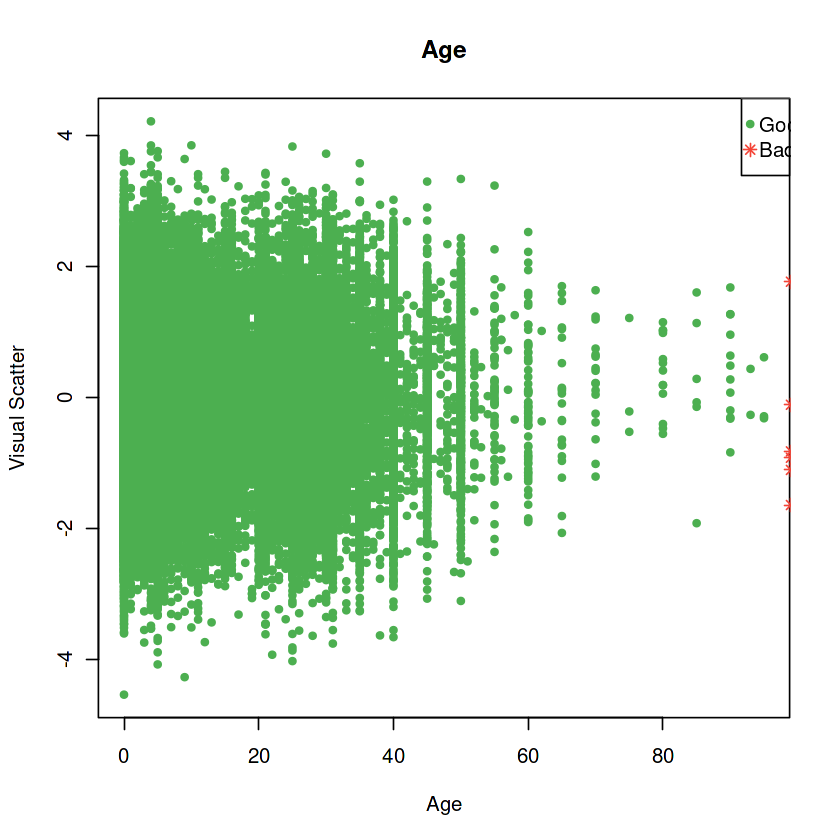

In [11]:
plot_outliers <- function(df, feature, threshold = 6) {
  mean_val <- mean(df)
  std_val <- sd(df)
  z_score <- abs((df - mean_val) / std_val)
  good <- z_score < threshold
  cat(paste0("Rejection ", sum(!good), " points\n"))
  visual_scatter <- rnorm(length(df))
  plot(df[good], visual_scatter[good], pch = 20, col = "#4CAF50",
       xlab = feature, ylab = "Visual Scatter", main = feature)
  points(df[!good], visual_scatter[!good], pch = 8, col = "#F44336")
  legend("topright", legend = c("Good", "Bad"), col = c("#4CAF50", "#F44336"), pch = c(20, 8))
  
  bad_indexes <- which(!good)
  
  return(bad_indexes)
}
bad_indexes <- integer()
bad_indexes <- c(bad_indexes, plot_outliers(df[["Age"]], "Age", threshold = 6))


Rejection 49 points


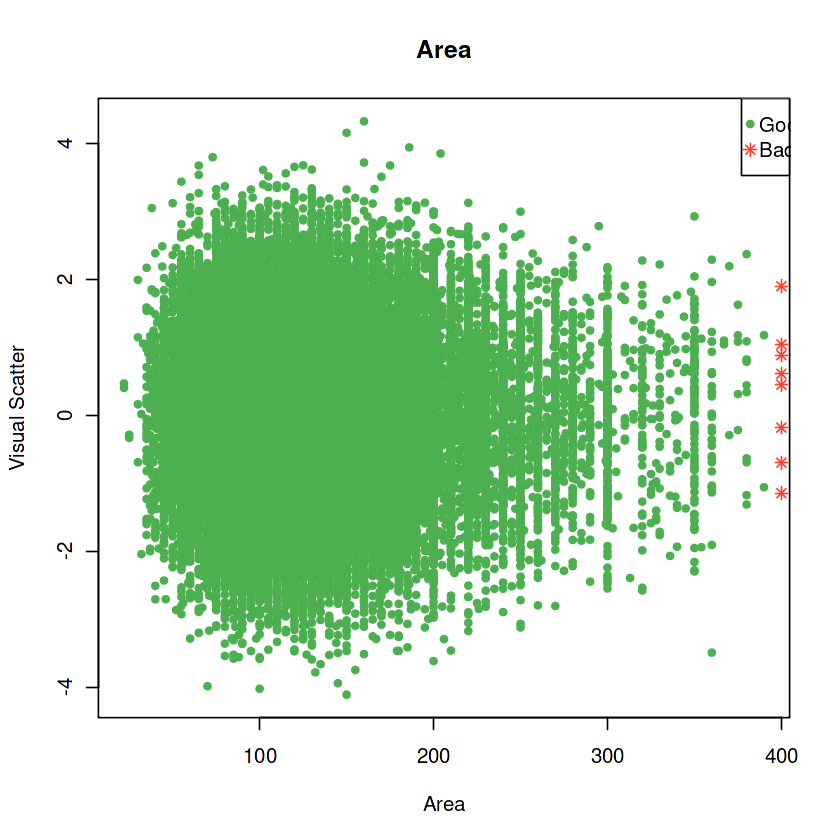

In [12]:
bad_indexes <- c(bad_indexes, plot_outliers(df[["Area"]], "Area", threshold = 6))

Rejection 0 points


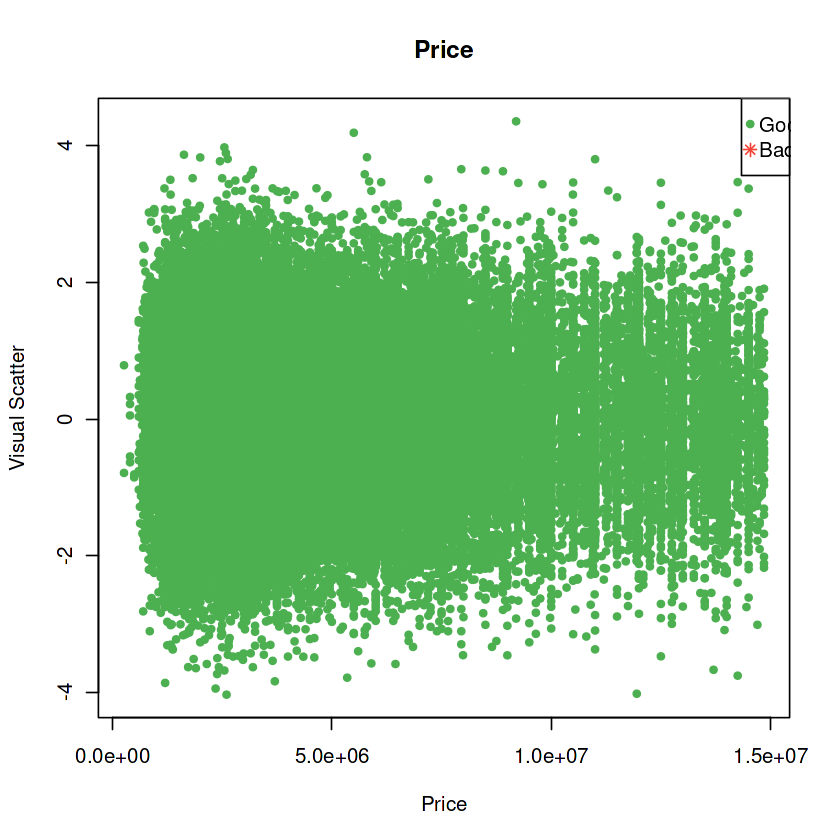

In [13]:
bad_indexes <- c(bad_indexes, plot_outliers(df[["Price"]], "Price", threshold = 6))

In [14]:
df <- df[-bad_indexes, ]


# Print general numerical information

In [15]:

# Subset the dataframe where "Location" is "Adalar" and "Kadıköy"
df_adalar <- subset(df, Location == "Adalar")
df_kadıköy <- subset(df, Location == "Kadıköy")


In [16]:

cat("Mean Price in İstanbul:",sprintf("%.2f",mean(df$Price)), "\n")
cat("Mean Price in Adalar: ", sprintf("%.2f", mean(df_adalar$Price) ), "\n")
cat("Mean Price in Kadıköy:", sprintf("%.2f", mean(df_kadıköy$Price)), "\n")

Mean Price in İstanbul: 4654160.13 
Mean Price in Adalar:  5101878.43 
Mean Price in Kadıköy: 6135021.14 


In [17]:
cat("Standard deviaiton in İstanbul:",sprintf("%.2f", sd(df$Price)), "\n")
cat("Standard deviaiton in Adalar:",sprintf("%.2f", sd(df_adalar$Price)), "\n")
cat("Standard deviaiton in Kadıköy:",sprintf("%.2f", sd(df_kadıköy$Price)), "\n")


Standard deviaiton in İstanbul: 3062794.29 
Standard deviaiton in Adalar: 3170740.26 
Standard deviaiton in Kadıköy: 3450193.76 


In [18]:
cat("Variance in İstanbul:",sprintf("%.2f", var(df$Price)), "\n")
cat("Variance in Adalar:",sprintf("%.2f", var(df_adalar$Price)), "\n")
cat("Variance in Kadıköy:",sprintf("%.2f", var(df_kadıköy$Price)), "\n")

Variance in İstanbul: 9380708848196.43 
Variance in Adalar: 10053593816233.29 
Variance in Kadıköy: 11903837013015.67 


# Plot distributions

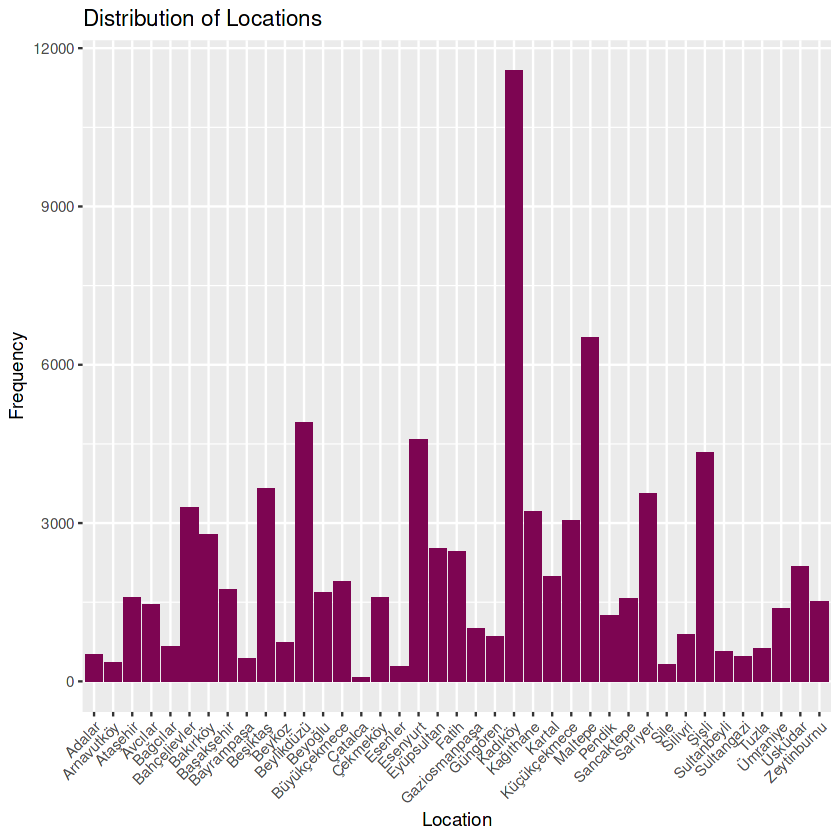

In [19]:
# Create a bar plot of the "Location" feature with rotated labels
bar_plot <- ggplot(df, aes(x = Location)) +
  geom_bar(fill = "#7D0552") +
  labs(x = "Location", y = "Frequency") +
  ggtitle("Distribution of Locations") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Display the bar plot
print(bar_plot)


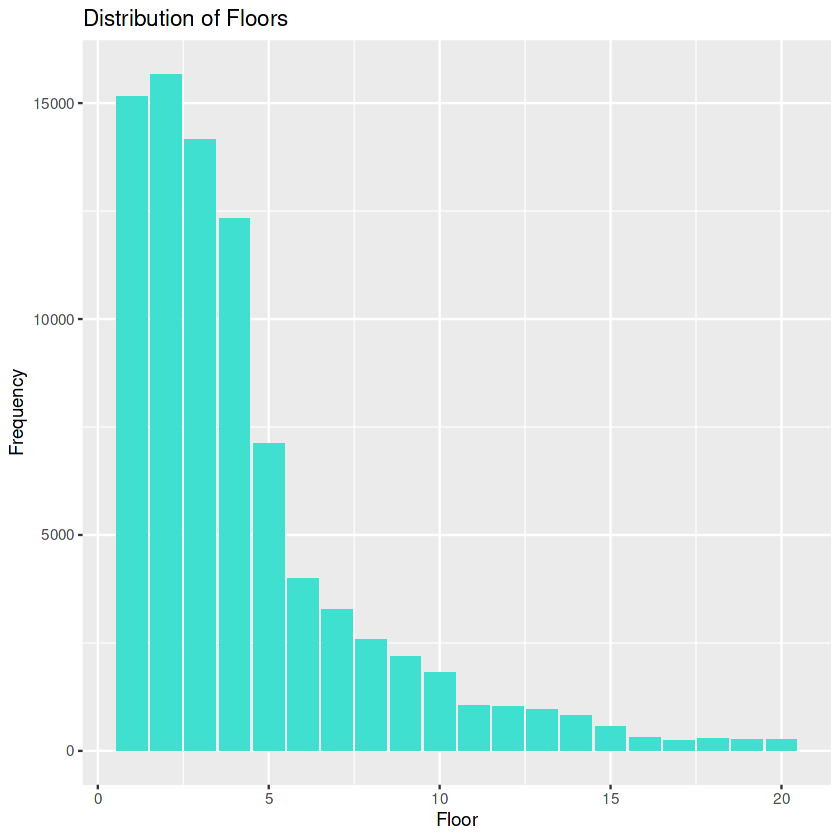

In [20]:
bar_plot <- ggplot(df, aes(x = Floor)) +
  geom_bar(fill = "turquoise") +
  labs(x = "Floor", y = "Frequency") +
  ggtitle("Distribution of Floors")
bar_plot

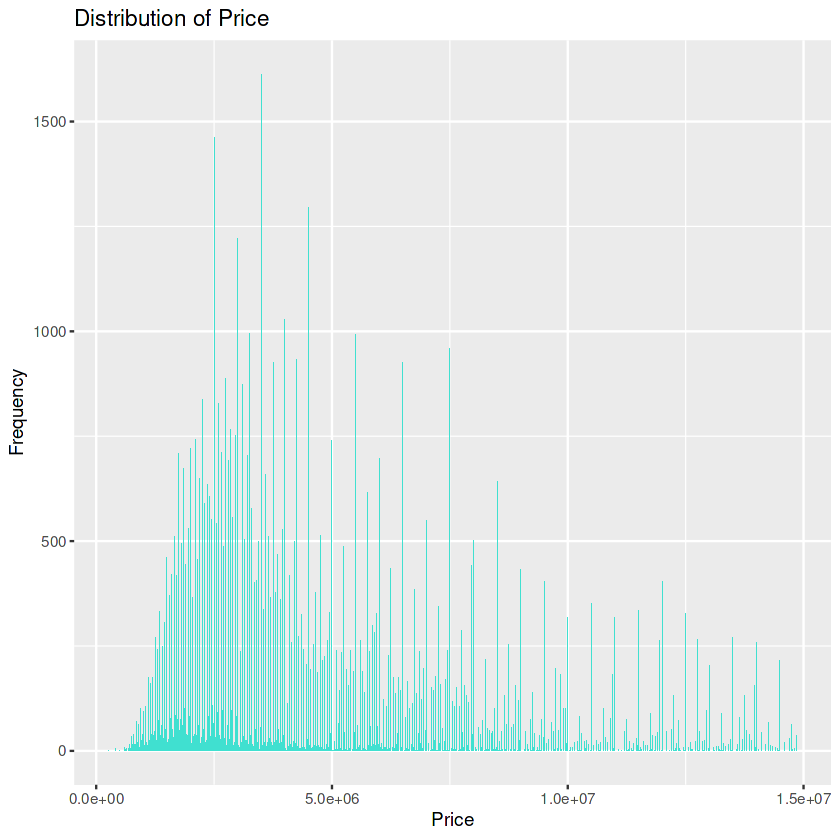

In [21]:
bar_plot <- ggplot(df, aes(x = Price)) +
  geom_bar(fill = "turquoise") +
  labs(x = "Price", y = "Frequency") +
  ggtitle("Distribution of Price")
bar_plot

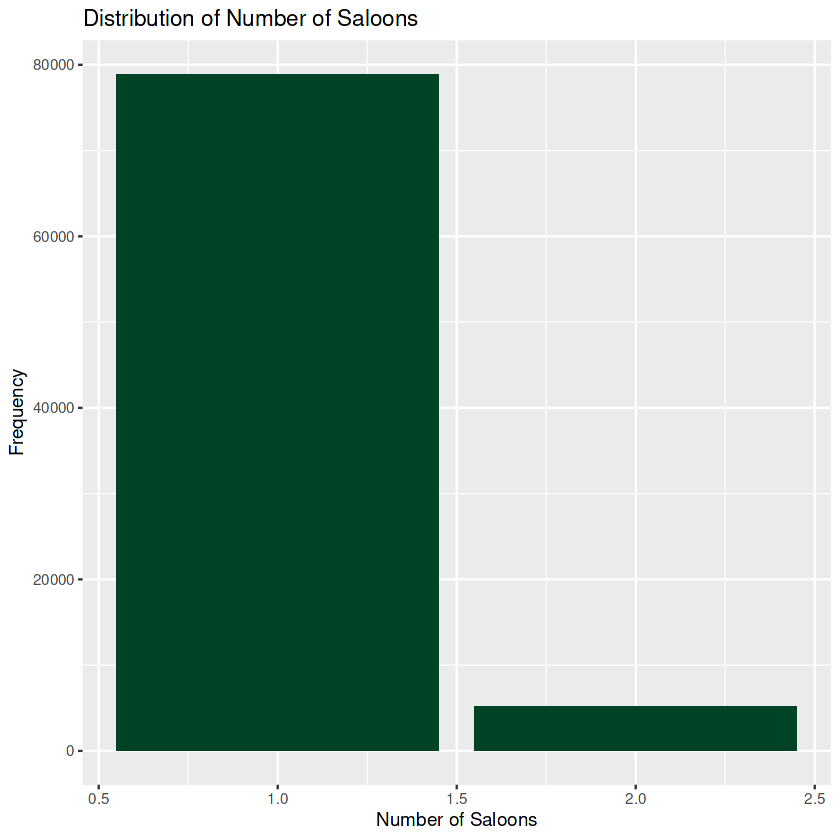

In [22]:
bar_plot <- ggplot(df, aes(x = saloon_num)) +
  geom_bar(fill = "#004225") +
  labs(x = "Number of Saloons", y = "Frequency") +
  ggtitle("Distribution of Number of Saloons")
bar_plot

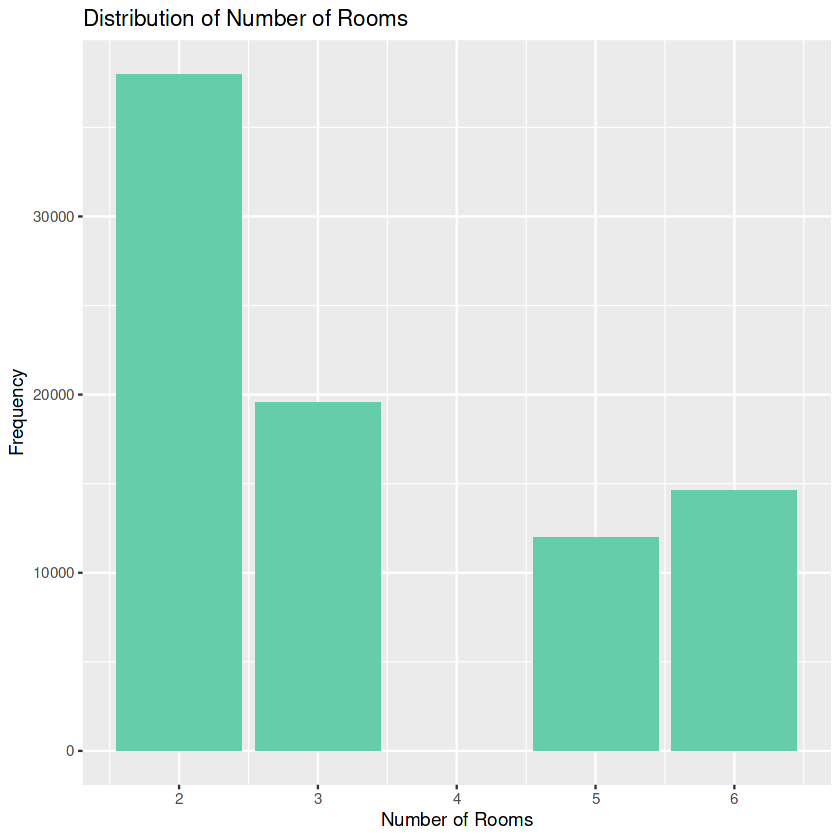

In [23]:
bar_plot <- ggplot(df, aes(x = room_num)) +
  geom_bar(fill = "MediumAquaMarine") +
  labs(x = "Number of Rooms", y = "Frequency") +
  ggtitle("Distribution of Number of Rooms")
bar_plot

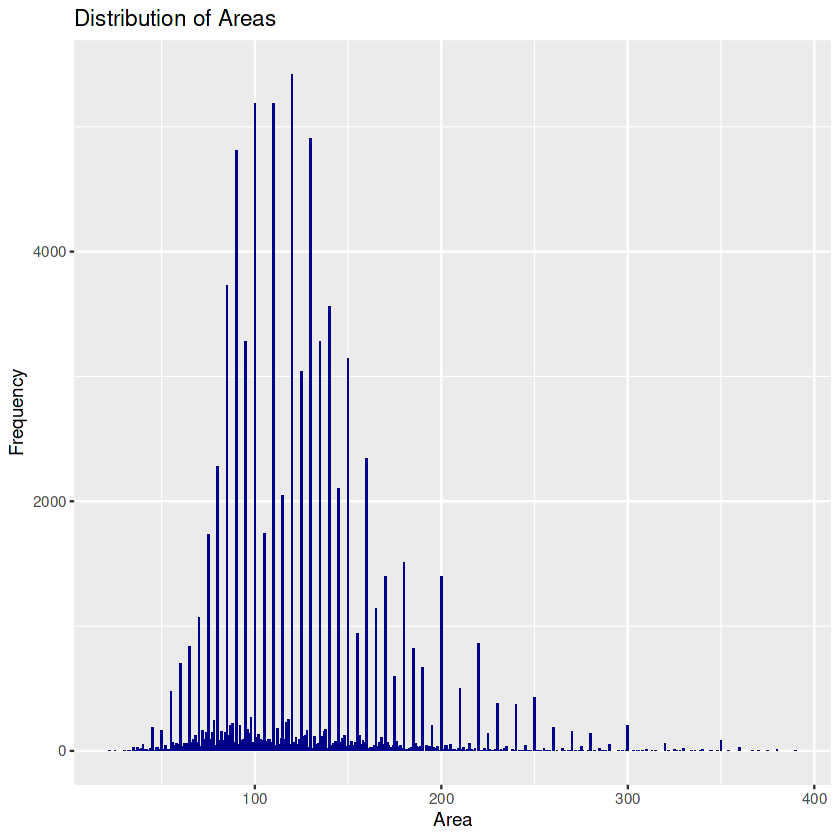

In [24]:
bar_plot <- ggplot(df, aes(x = Area)) +
  geom_bar(fill = "Dark Blue") +
  labs(x = "Area", y = "Frequency") +
  ggtitle("Distribution of Areas")
bar_plot

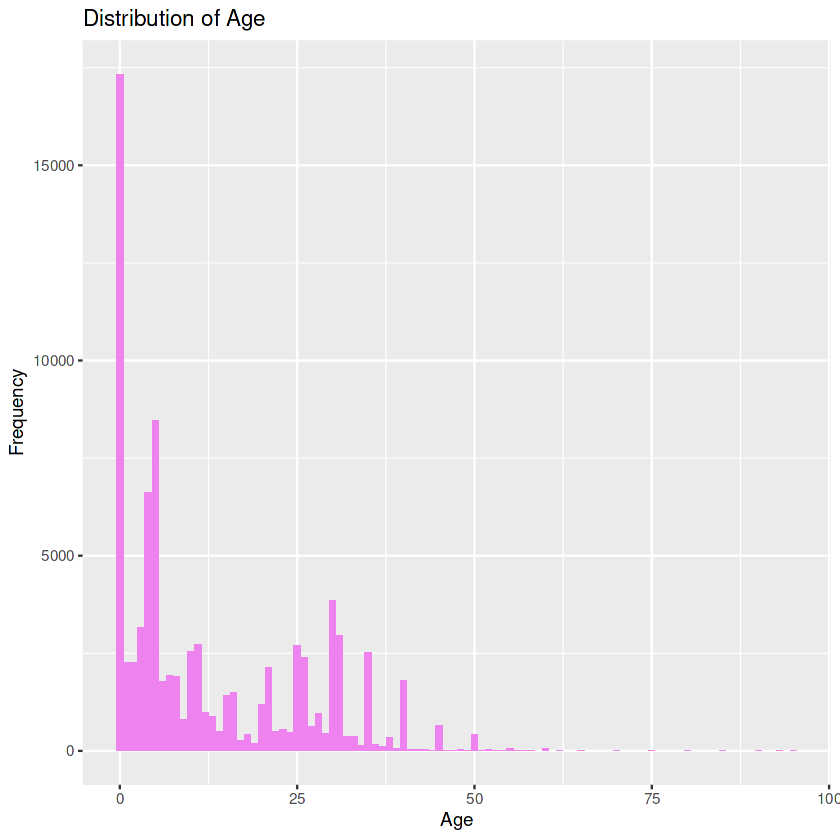

In [25]:
bar_plot <- ggplot(df, aes(x = Age)) +
  geom_bar(fill = "violet") +
  labs(x = "Age", y = "Frequency") +
  ggtitle("Distribution of Age")
bar_plot

# Finite Population Correction Factor

In [26]:
# Define mean_price_adalar (assuming it's already calculated)
mean_price_adalar <- 6699896.74

# Calculate population size
population_size <- nrow(df)

sample_size_adalar <- nrow(df_adalar)

# Calculate Finite Population Correction Factor (fpf)
fpf <- sqrt((population_size - sample_size_adalar) / (population_size - 1))

# Calculate corrected mean price in Adalar
corrected_mean_price_adalar <- mean_price_adalar * fpf

# Print the result
cat("Mean Price in Adalar:", sprintf("%.2f", corrected_mean_price_adalar), "\n")


Mean Price in Adalar: 6679591.26 


# Margin of Error

In [27]:
#Margin of error for prices in Adalar
confidence_level <- 0.95

# Calculate the margin of error
margin_of_error <- qt((1 - confidence_level) / 2, df = length(df_adalar$Price) - 1) * (sd(df_adalar$Price) / sqrt(length(df_adalar$Price)))

# Print the result
cat("Margin of Error:", sprintf("%.2f", abs(margin_of_error)), "\n")

Margin of Error: 275840.21 


# Skewness

In [28]:
pc_skewness <- skewness(df$Price)

# Print the Pearson Coefficient of skewness
cat("Pearson Coefficient of Skewness:", pc_skewness)


Pearson Coefficient of Skewness: 1.260714

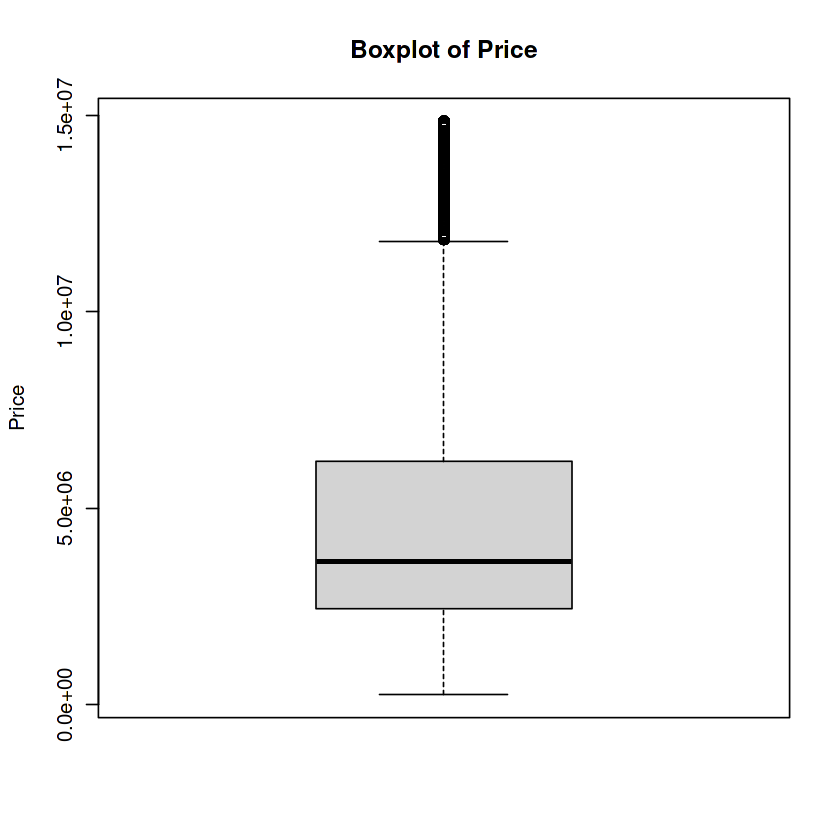

In [29]:
boxplot(df$Price, main = "Boxplot of Price", ylab = "Price")


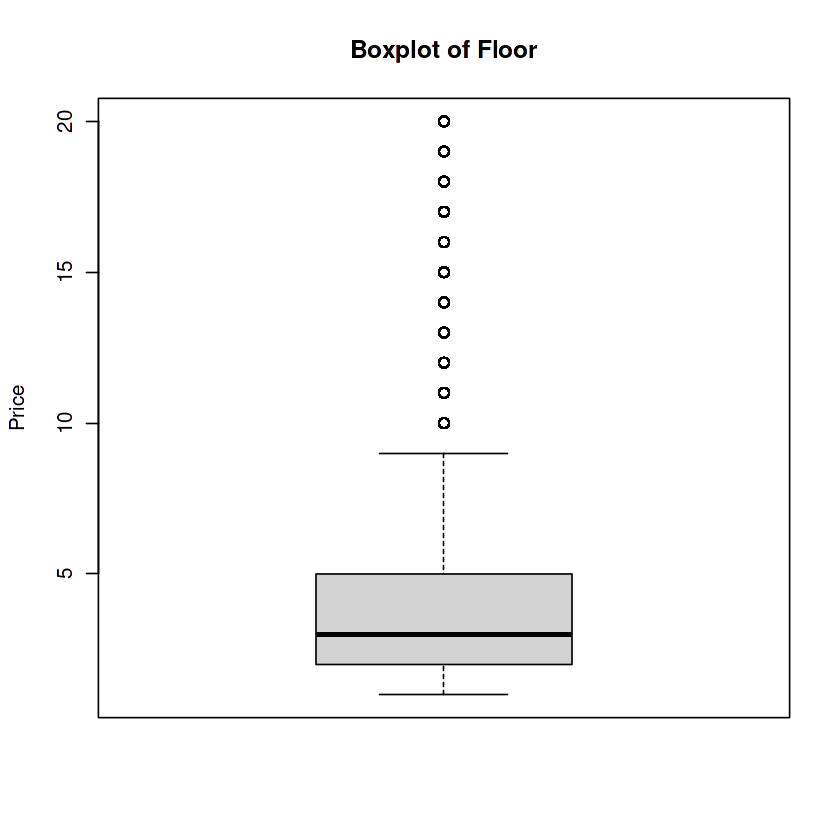

In [30]:
boxplot(df$Floor, main = "Boxplot of Floor", ylab = "Price")


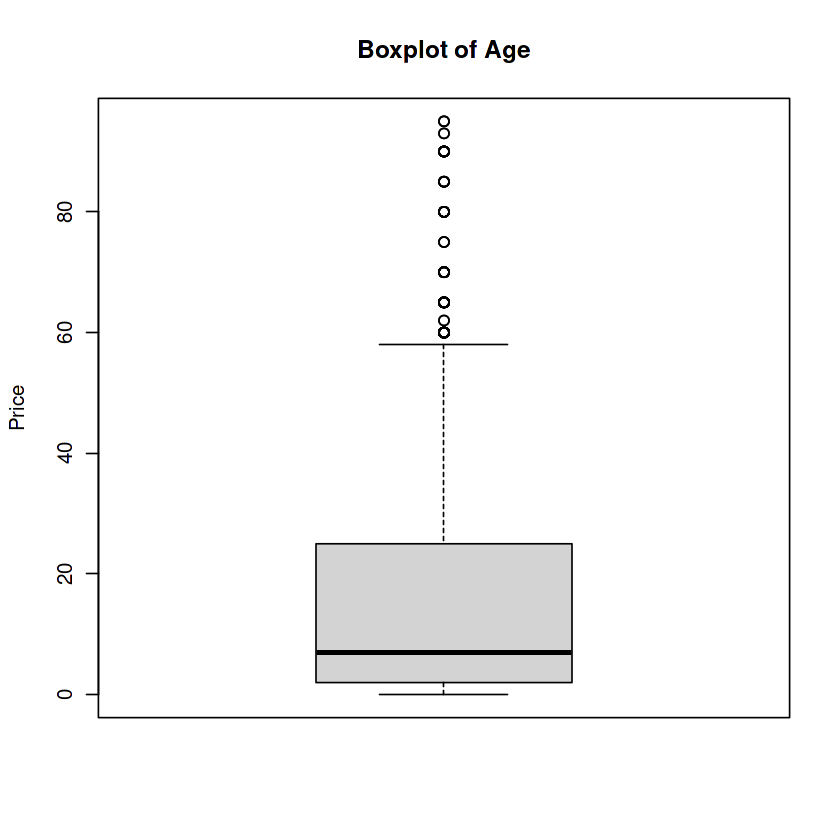

In [31]:
boxplot(df$Age, main = "Boxplot of Age", ylab = "Price")


# $\tilde{\chi}^2$ test example

In [32]:
# Set parameters
alpha <- 0.05
sample_size <- 1000
num_samples <- 50
p_values <- numeric(num_samples)

# Perform chi-square test for each sample
for (i in 1:num_samples) {
  random_sample <- df[sample(nrow(df), size = sample_size, replace = FALSE), ]
  contingency_table <- table(random_sample$Location, random_sample$room_num)
  result <- suppressWarnings(chisq.test(contingency_table))
  p_values[i] <- result$p.value
}
# Print the p-value
cat("p-value:", result$p.value, "\n")
# Check if null hypothesis is rejected
if (mean(p_values) < alpha) {
  print("Reject null hypothesis. There is evidence of an association between location and number of rooms.")
} else {
  print("Fail to reject null hypothesis. There is no evidence of an association between location and number of rooms.")
}


p-value: 0.03532415 
[1] "Fail to reject null hypothesis. There is no evidence of an association between location and number of rooms."


# T-Test


In [33]:
# Extract the necessary columns
rooms_2 <- subset(df, room_num == 2)
rooms_3 <- subset(df, room_num == 3)

# Extract the age values for the two groups
age_2 <- rooms_2$Age
age_3 <- rooms_3$Age

# Perform t-test
result <- t.test(age_2, age_3)

# Set the significance level
alpha <- 0.05

# Print the p-value
cat("p-value:", result$p.value, "\n")

# Check the p-value against the significance level
if (result$p.value < alpha) {
  cat("Reject the null hypothesis\n")
  cat("Mean age of properties with 2 rooms is different from the mean age of properties with 3+1 rooms\n")
} else {
  cat("Fail to reject the null hypothesis\n")
  cat("Mean age of properties with 2 rooms is equal to the mean age of properties with 3+1 rooms\n")
}

p-value: 0.0875172 
Fail to reject the null hypothesis
Mean age of properties with 2 rooms is equal to the mean age of properties with 3+1 rooms


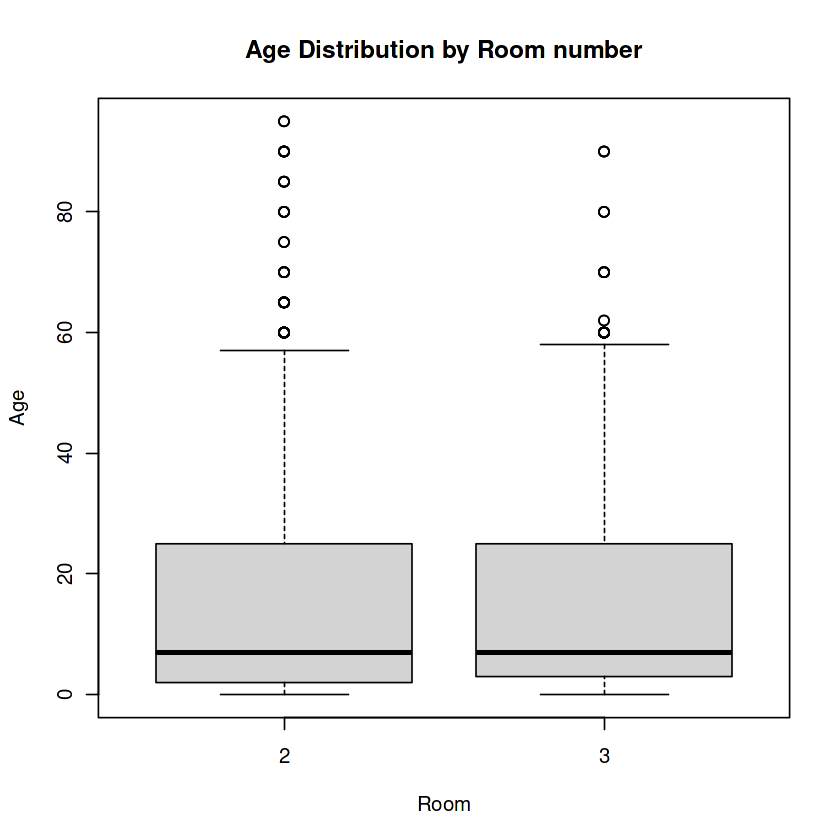

In [34]:
# Extract the necessary columns
room_2 <- subset(df, room_num == 2)
room_3 <- subset(df, room_num == 3)

# Create a box plot
boxplot(list(room_2$Age, room_3$Age), names = c(2,3),
        xlab = "Room", ylab = "Age", main = "Age Distribution by Room number")

# Z-Test

In [35]:
# Extract the price values from the dataset
prices <- df$Price

# Specify the specific value for the null hypothesis
specific_value <- 2000000

# Calculate the sample mean and population standard deviation
mean <- mean(prices)
std <- sd(prices)

# Calculate the sample size
n <- length(prices)

# Compute the test statistic (z-score)
z_score <- (mean - specific_value) / (std / sqrt(n))

# Set the significance level
alpha <- 0.05

# Calculate the critical value(s) from the standard normal distribution
critical_value <- qnorm(1 - alpha / 2)  # for a two-tailed test

# Print the z-score and p-value
cat("z-score:", z_score, "\n")
p_value <- 2 * (1 - pnorm(abs(z_score)))  # for a two-tailed test
cat("p-value:", p_value, "\n")

# Compare the test statistic and critical value
if (abs(z_score) > critical_value) {
  cat("Reject the null hypothesis\n")
  cat("The average price of properties in Adalar is different from", specific_value, "\n")
} else {
  cat("Fail to reject the null hypothesis\n")
  cat("The average price of properties in Adalar is equal to", specific_value, "\n")
}


z-score: 251.3116 
p-value: 0 
Reject the null hypothesis
The average price of properties in Adalar is different from 2e+06 


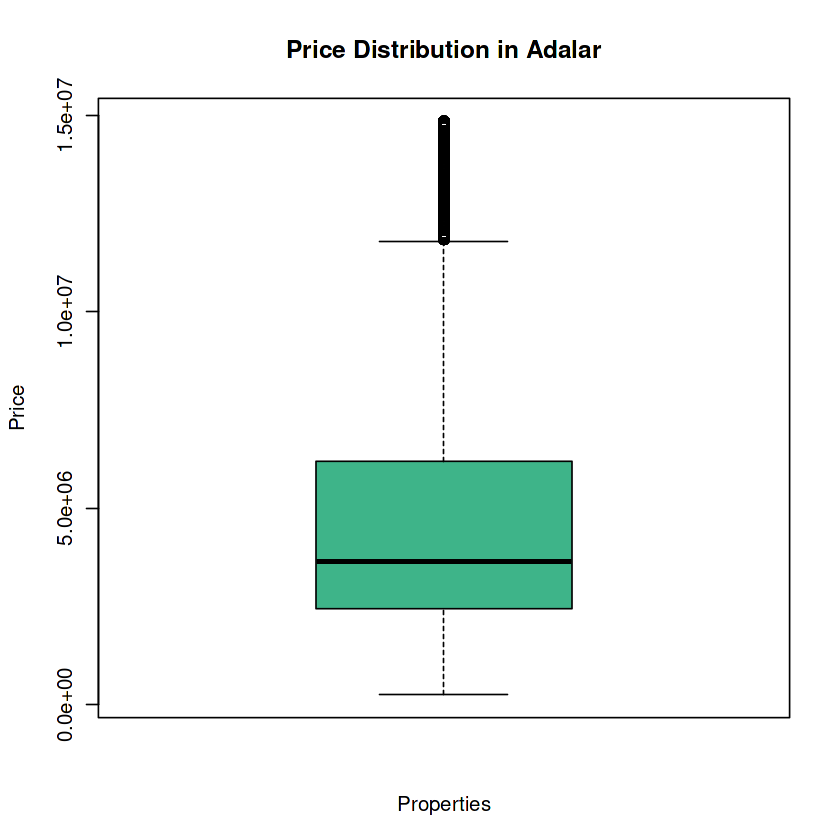

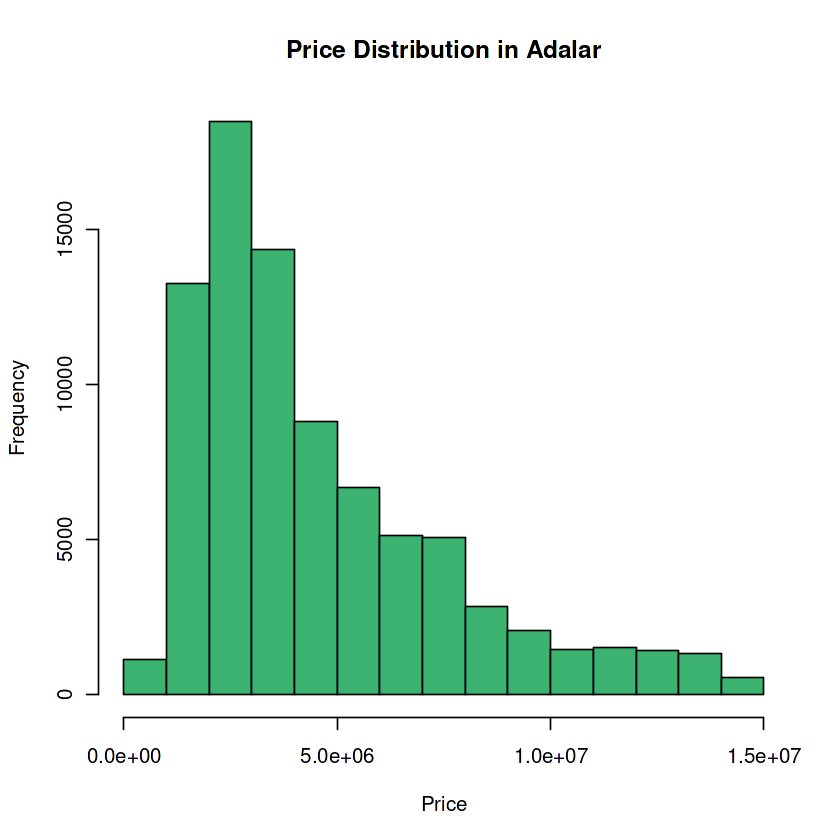

In [36]:
# Create a box plot
boxplot(prices, xlab = "Properties", ylab = "Price", main = "Price Distribution in Adalar", col = "#3EB489")

# Create a histogram of prices
hist(prices, breaks = 20, xlab = "Price", ylab = "Frequency", main = "Price Distribution in Adalar", col ="#3CB371")

# Normality Test

In [37]:

# Set the seed for reproducibility
set.seed(42)

# Assuming your dataset is named 'house_data' and the 'Price' column is in the first column
# Convert the 'Price' column to numeric format
df$Price <- as.numeric(df$Price)

# Take a random sample of size 1000 from the 'Price' column
sample_data <- sample(df$Price, 1000)

# Perform Shapiro-Wilk test on the sample
result <- shapiro.test(sample_data)
print(result)




	Shapiro-Wilk normality test

data:  sample_data
W = 0.87737, p-value < 2.2e-16



In [38]:
dim(df)

[1] 84102     7

In [39]:
alpha <- 0.05

# Step 2: Calculate the point estimate
mean_price <- mean(df$Price)

# Step 3: Calculate the standard error
se <- sd(df$Price) / sqrt(length(df$Price))

# Step 4: Determine the critical value
# Since the sample size is large (90,000 rows), we can use the Z-score
z <- qnorm(1 - alpha / 2)

# Step 5: Calculate the margin of error
margin_of_error <- z * se

# Step 6: Calculate the confidence interval
lower_bound <- mean_price - margin_of_error
upper_bound <- mean_price + margin_of_error

# Print the confidence interval
cat("Confidence Interval for Mean Price (95% confidence): [", lower_bound, ",", upper_bound, "]")


Confidence Interval for Mean Price (95% confidence): [ 4633460 , 4674860 ]

In [40]:
x <- df$Price
y <- df$Area

# Calculate the correlation coefficient
correlation <- cor(x, y)

# Calculate the degrees of freedom
n <- length(x)
df1 <- 1  # Degrees of freedom for the numerator (number of predictors - 1)
df2 <- n - 2  # Degrees of freedom for the denominator (total sample size - number of predictors)

# Calculate the F statistic
F <- (correlation^2 * df2) / ((1 - correlation^2) * df1)

# Calculate the p-value using the F distribution
p_value <- 1 - pf(F, df1, df2)

# Print the results
cat("Correlation coefficient:", correlation, "\n")
cat("F statistic:", F, "\n")
cat("p-value:", p_value, "\n")



Correlation coefficient: 0.4651531 
F statistic: 23220.7 
p-value: 0 


# Machine Learning Models

In [41]:
# regression_dataset <- subset(df, select = -Room) # discard room column
regression_dataset <- cbind(df, model.matrix(~ Location - 1, data = df)) # one hot encoding on location
regression_dataset <- subset(regression_dataset, select = -Location) # discard location column
regression_dataset <- regression_dataset[sample(nrow(regression_dataset)), ] # shuffle dataset

head(regression_dataset)

,Price,Area,Age,Floor,room_num,saloon_num,LocationAdalar,LocationArnavutköy,LocationAtaşehir,LocationAvcılar,⋯,LocationSarıyer,LocationŞile,LocationSilivri,LocationŞişli,LocationSultanbeyli,LocationSultangazi,LocationTuzla,LocationÜmraniye,LocationÜsküdar,LocationZeytinburnu
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19990,2450000,100,5,2,3,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80083,3500000,130,18,1,5,2,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
29950,5200000,190,3,3,3,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
37144,3500000,80,13,1,2,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
18555,5000000,163,16,2,2,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
12110,5400000,169,8,3,5,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Linear Regression model

In [42]:
# Split the data into training and testing sets (if desired)
set.seed(123)  # Set a seed for reproducibility
train_indices <- sample(1:nrow(regression_dataset), 0.8 * nrow(regression_dataset))  # 80% for training
train_data <- regression_dataset[train_indices, ]
test_data <- regression_dataset[-train_indices, ]

# Fit the linear regression model
model <- lm(Floor ~ ., data = train_data)  # Use all columns as independent variables (except "Price")

# Make predictions on the test set
predictions <- suppressWarnings(predict(model, newdata = test_data))

# Evaluate the model
mse <- mean((test_data$Floor - predictions)^2)  # Calculate the mean squared error
mse

[1] 11.17365

## Gradient Boosting Model

In [43]:
# Fit a gradient boosting model
model <- gbm(Floor ~ ., data = train_data)

# Make predictions on the test set
predictions <- predict(model, newdata = test_data)

# Evaluate the model
mse <- mean((test_data$Floor - predictions)^2)
mse

Distribution not specified, assuming gaussian ...


Using 100 trees...




[1] 10.82721

## Xgboost model

In [44]:
# Convert the data to DMatrix format required by XGBoost
train_matrix <- xgb.DMatrix(as.matrix(train_data[, -1]), label = train_data$Floor)
test_matrix <- xgb.DMatrix(as.matrix(test_data[, -1]), label = test_data$Floor)

# Define the parameters for XGBoost
params <- list(objective = "reg:squarederror", eval_metric = "rmse")

# Train the XGBoost model
model <- xgb.train(params, train_matrix, nrounds = 100)

# Make predictions on the test set
predictions <- predict(model, test_matrix)

# Evaluate the model
mse <- mean((test_data$Floor - predictions)^2)
mse

[1] 2.27295e-11

In [45]:
head(regression_dataset)

,Price,Area,Age,Floor,room_num,saloon_num,LocationAdalar,LocationArnavutköy,LocationAtaşehir,LocationAvcılar,⋯,LocationSarıyer,LocationŞile,LocationSilivri,LocationŞişli,LocationSultanbeyli,LocationSultangazi,LocationTuzla,LocationÜmraniye,LocationÜsküdar,LocationZeytinburnu
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19990,2450000,100,5,2,3,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80083,3500000,130,18,1,5,2,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
29950,5200000,190,3,3,3,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
37144,3500000,80,13,1,2,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
18555,5000000,163,16,2,2,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
12110,5400000,169,8,3,5,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# Correlation Matrix

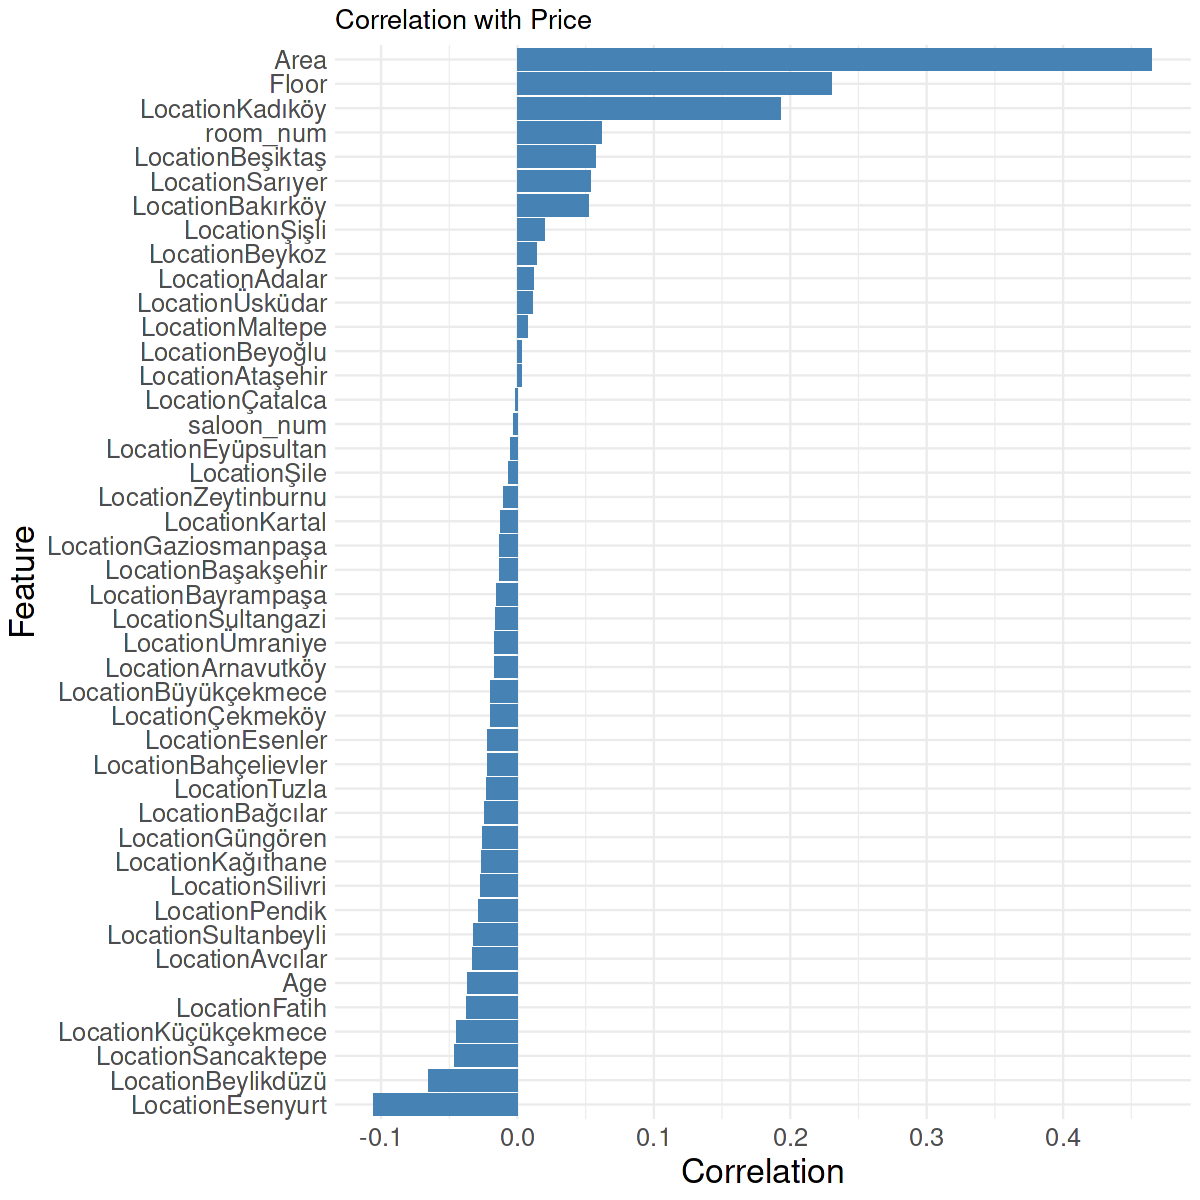

In [46]:
corr <- cor(regression_dataset)[, "Price"]
corr <- corr[order(-abs(corr))]  # Sort correlation values in descending order

# Remove correlation with Price itself
corr <- corr[!names(corr) %in% "Price"]

corr_df <- data.frame(Correlation = corr, Feature = names(corr))
corr_df <- corr_df[order(-abs(corr_df$Correlation)), ]  # Sort dataframe by correlation values
options(repr.plot.width = 10, repr.plot.height = 10)  # Adjust the width and height as needed

ggplot(corr_df, aes(x = reorder(Feature, Correlation), y = Correlation)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(x = "Feature", y = "Correlation") +
  ggtitle("Correlation with Price") +
  theme_minimal() +
  theme(plot.title = element_text(size = 16), 
        axis.text = element_text(size = 15), 
        axis.title = element_text(size = 20))

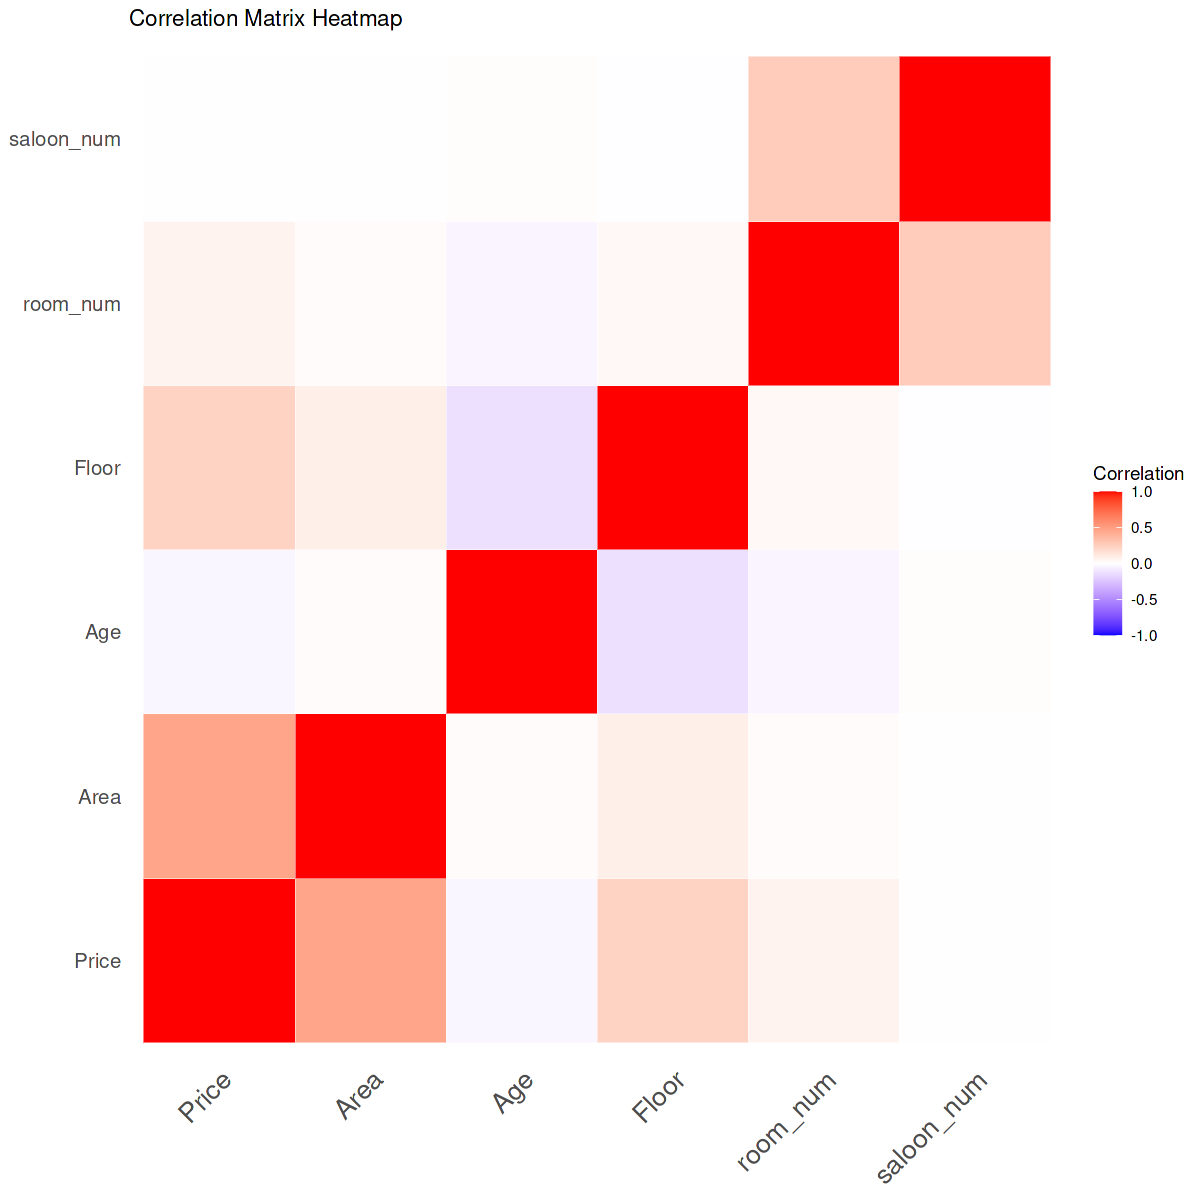

In [47]:
df_numerical <- subset(df, select = -c(Location) )
correlation_matrix <- cor(df_numerical)

# Convert the correlation matrix to a long format
correlation_data <- melt(correlation_matrix)

# Set the row and column names
row_names <- rownames(correlation_matrix)
col_names <- colnames(correlation_matrix)

# Plot the heatmap
ggplot(correlation_data, aes(Var2, Var1, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab",
                       name = "Correlation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 16),  # Adjust the 'size' parameter for x-axis labels
        axis.text.y = element_text(size = 12),  # Adjust the 'size' parameter for y-axis labels
        axis.title = element_blank(),
        panel.grid = element_blank()) +

  labs(title = "Correlation Matrix Heatmap")


# ANOVA

In [48]:
# Perform ANOVA
anova_result <- aov(Price ~ factor(Age), data = regression_dataset)

# Print the ANOVA table
print(summary(anova_result))

               Df    Sum Sq   Mean Sq F value Pr(>F)    
factor(Age)    68 1.015e+16 1.493e+14   16.11 <2e-16 ***
Residuals   84033 7.788e+17 9.268e+12                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [49]:
# Perform ANOVA
anova_result <- aov(Price ~ factor(saloon_num), data = regression_dataset)

# Print the ANOVA table
print(summary(anova_result))

                      Df    Sum Sq   Mean Sq F value Pr(>F)
factor(saloon_num)     1 7.720e+12 7.720e+12   0.823  0.364
Residuals          84100 7.889e+17 9.381e+12               


# Visualization of Central Limit Theorem


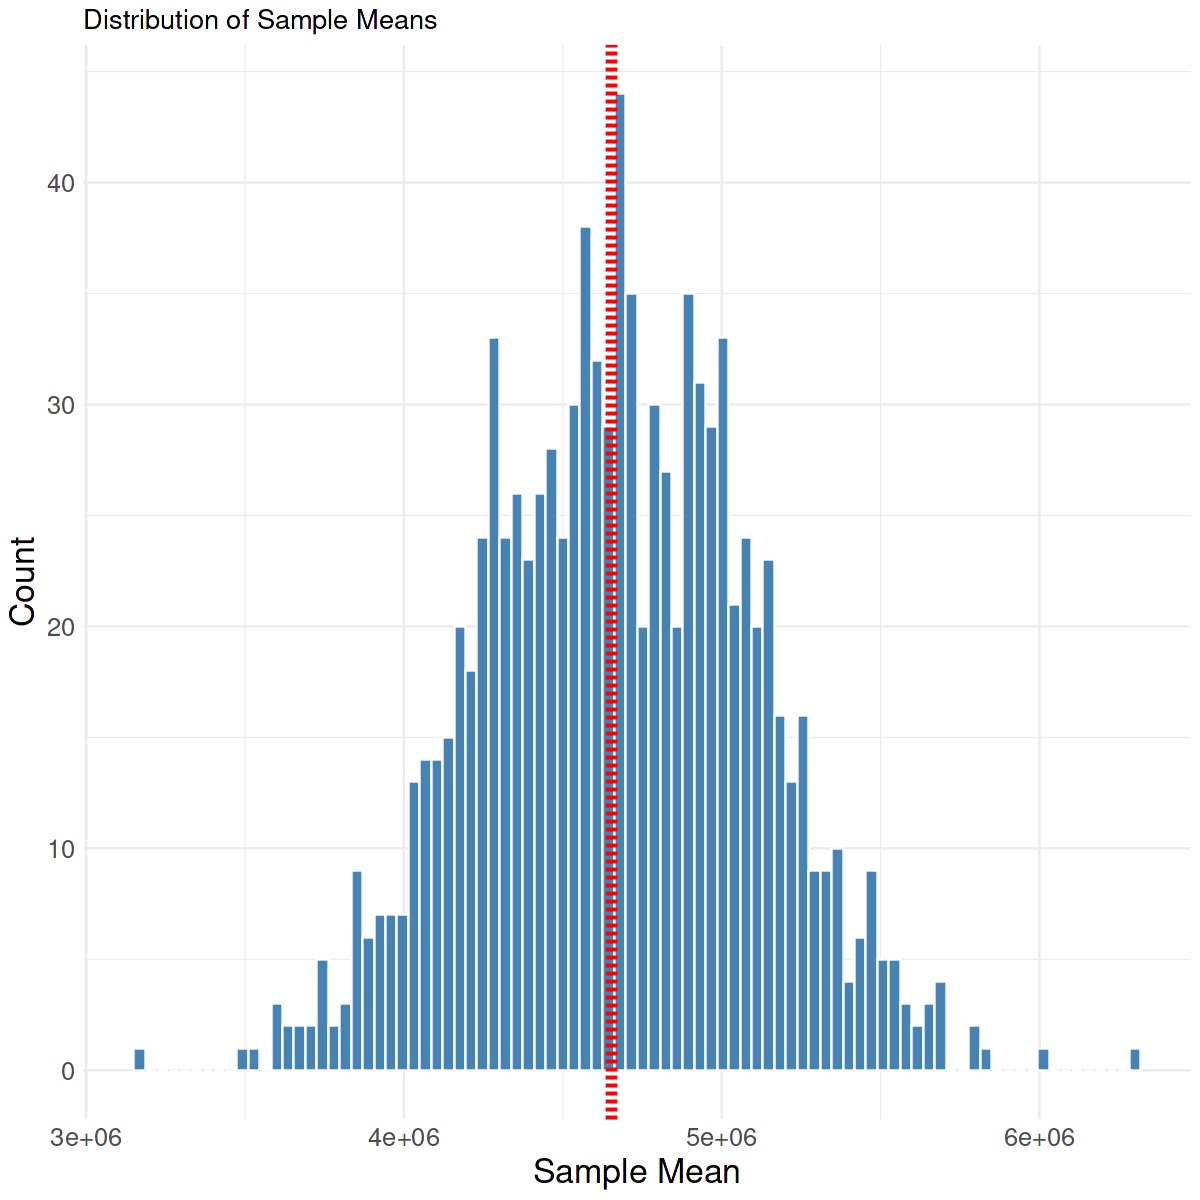

In [50]:
prices <- df$Price
real_mean <- mean(prices)
n_samples <- 1000  # Number of samples to generate
sample_size <- 50  # Sample size for each sample

# get all the means of these random samples using for loop and sample function
# to gather these means in a vector
sample_means <- c()
for (i in 1:n_samples) {
  example_sample <- sample(prices, sample_size)
  sample_means <- c(sample_means, mean(example_sample))
}

# Plot the distribution of sample means
options(repr.plot.width = 10, repr.plot.height = 10)  # Adjust the width and height as needed

ggplot(data.frame(sample_means), aes(x = sample_means)) +
  geom_histogram(binwidth = 36000, fill = "steelblue", color = "white") +
  geom_vline(xintercept = real_mean, color = "red", linetype = "dashed", linewidth = 2.5) +
  labs(x = "Sample Mean", y = "Count") +
  ggtitle("Distribution of Sample Means") +
  theme_minimal() +
  theme(plot.title = element_text(size = 16), 
        axis.text = element_text(size = 15), 
        axis.title = element_text(size = 20))

# Goodness of Fit test

In [51]:
# Perform the goodness-of-fit test
observed <- table(df$Area)
expected <- rep(1/length(observed), length(observed))  # Assuming uniform distribution
chi2 <- chisq.test(observed, p = expected)
chi2


	Chi-squared test for given probabilities

data:  observed
X-squared = 689025, df = 272, p-value < 2.2e-16


Based on these results, we can conclude that the observed frequencies of the "Area" feature significantly deviate from a uniform distribution. This implies that there are differences in the distribution of properties across different locations in the dataset.

# Mann-Whitney U test 

In [52]:
kartal_sariyer_df <- subset(df, Location %in% c("Kartal", "Sarıyer"))
result <- wilcox.test(Price ~ Location, data = kartal_sariyer_df)
p_value <- result$p.value
cat("p-value:", result$p.value, "\n")
if (p_value < 0.05) {
  print("There is a significant difference in prices between Kartal and Sarıyer.")
} else {
  print("There is no significant difference in prices between Kartal and Sarıyer.")
}

p-value: 1.585256e-33 
[1] "There is a significant difference in prices between Kartal and Sarıyer."
